In [1]:
import scanpy as sc
#import numpy as np
#import pandas as pd
#sc.settings.verbosity = 3
#sc.logging.print_versions()

In [3]:
import rpy2.rinterface_lib.callbacks
import logging

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import anndata2ri
anndata2ri.activate()

In [4]:
#data_dir = '../'
adata = sc.read('../testing.h5ad')
#sc.pp.subsample(adata, 0.3)

In [8]:
%load_ext rpy2.ipython

In [5]:
ro.r('library(conos)')

array(['conos', 'igraph', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

In [6]:
ro.r('library(Seurat)')

array(['Seurat', 'conos', 'igraph', 'Matrix', 'tools', 'stats',
       'graphics', 'grDevices', 'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [23]:
test = adata.X

In [19]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [25]:
ro.globalenv['adata'] = adata

RRuntimeError: Error in validObject(.Object) : 
  invalid class “dgRMatrix” object: slot j is not increasing inside a column
Calls: <Anonymous> ... initialize -> callNextMethod -> .nextMethod -> validObject


In [11]:
adata.__class__

anndata.core.anndata.AnnData

In [7]:
ro.r('sobj = as.Seurat(adata, counts = "counts", data = "X")')
ro.r('batch_list = SplitObject(sobj, split.by = "method")')

FACS,[RTYPES.S4SXP]
droplet,[RTYPES.S4SXP]


In [8]:
ro.r('anchors = FindIntegrationAnchors('+
        'object.list = batch_list, '+
        'anchor.features = 10000,'+
        'scale = T,'+
        'l2.norm = T,'+
        'dims = 1:30,'+
        'k.anchor = 5,'+
        'k.filter = 200,'+
        'k.score = 30,'+
        'max.features = 200,'+
        'eps = 0)'
    )

R object with classes: ('AnchorSet',) mapped to:

In [137]:
ro.r('integrated = IntegrateData('+
        'anchorset = anchors,'+
        'new.assay.name = "integrated",'+
        'features = NULL,'+
        'features.to.integrate = NULL,'+
        'dims = 1:100,'+
        'k.weight = 100,'+
        'weight.reduction = NULL,'+
        'sd.weight = 1,'+
        'sample.tree = NULL,'+
        'preserve.order = F,'+
        'do.cpp = T,'+
        'eps = 0,'+
        'verbose = T)'
    )

R object with classes: ('Seurat',) mapped to:

In [138]:
integrated = ro.r('as.SingleCellExperiment(integrated)')

In [139]:
integrated

AnnData object with n_obs × n_vars = 11829 × 3329 
    obs: 'G2M_score', 'S_score', 'barcode', 'batch', 'cell_ontology_class', 'log_counts', 'method', 'mt_frac', 'n_counts', 'n_genes', 'phase', 'sID', 'sample', 'sex', 'size_factors', 'tissue', 'louvain', 'nCount_RNA', 'nFeature_RNA', 'ident'

In [140]:
import os
import sys
sys.path.append(os.path.abspath("../"))
import utils

In [141]:
integrated.X

<11829x3329 sparse matrix of type '<class 'numpy.float32'>'
	with 17939698 stored elements in Compressed Sparse Row format>

In [142]:
utils.summarize_counts(integrated)

In [143]:
sc.pp.pca(integrated)
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

/home/m/muellermi/bin/miniconda3/envs/sc_tutorial/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


... storing 'batch' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'method' as categorical
... storing 'phase' as categorical
... storing 'sID' as categorical
... storing 'sample' as categorical
... storing 'sex' as categorical
... storing 'tissue' as categorical
... storing 'louvain' as categorical


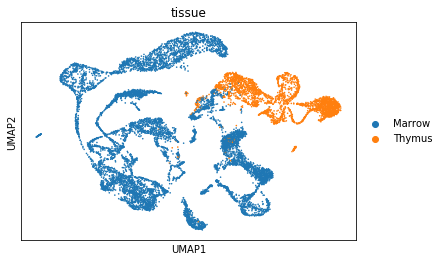

In [144]:
sc.pl.umap(integrated, color='tissue')

In [1]:
import scIB

In [5]:
import pandas as pd

In [14]:
def readConos(path):
    from scipy.io import mmread
    import scanpy as sc
    gene_df = pd.read_csv(path + "genes.csv")

    metadata = pd.read_csv(path + "metadata.csv")
    metadata.index = metadata.CellId
    del metadata["CellId"]

    embedding_df = pd.read_csv(path + "embedding.csv")
    # Decide between using PCA or pseudo-PCA
    pseudopca_df = pd.read_csv(path + "pseudopca.csv")
    #pca_df = pd.read_csv(path + "pca.csv")

    graph_conn_mtx = mmread(path + "graph_connectivities.mtx")
    graph_dist_mtx = mmread(path + "graph_distances.mtx")
    
    adata = sc.read_mtx(path+ "raw_count_matrix.mtx")
    
    
    adata.var_names = gene_df["gene"].values
    adata.obs_names = metadata.index.values

    adata.obs = metadata.copy()

    # Depends on which PCA you loaded
    adata.X_pca = pseudopca_df.values
    adata.obsm['X_pca'] = pseudopca_df.values

    # Name according to embedding you saved
    adata.X_umap = embedding_df.values
    adata.obsm['X_umap'] = embedding_df.values

    adata.uns['neighbors'] = dict(connectivities=graph_conn_mtx.tocsr(), distances=graph_dist_mtx.tocsr())

    # Assign raw counts to .raw slot, load in normalised counts
    #adata.raw = adata
    #adata_temp = sc.read_mtx(DATA_PATH + "count_matrix.mtx")
    #adata.X = adata_temp.X
    
    return adata

In [12]:
from scipy.io import mmread
mmread('/home/icb/daniel.strobl/conosT/graph_connectivities.mtx')

<26668x26668 sparse matrix of type '<class 'numpy.float64'>'
	with 527542 stored elements in COOrdinate format>

In [16]:
adata = readConos('/home/icb/daniel.strobl/conosT/')

In [18]:
import scanpy as sc
sc.tl.umap(adata)

KeyError: 'params'

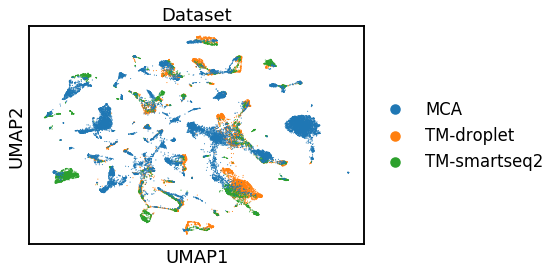

In [24]:
sc.pl.umap(adata, color='Dataset')

In [23]:
adata.obs

,Dataset
CellId,
GGCAATTCATTCTCAT-0-1-1,TM-droplet
GTACTTTAGCCGGTAA-3-1-1,TM-droplet
TACACGACAAGCTGTT-5-1-1,TM-droplet
ACTGTCCCAAACGTGG-5-1-1,TM-droplet
TGCACCTGTACATGTC-1-1-1,TM-droplet
GCTGGGTCAGTATAAG-7-1-1,TM-droplet
CATGACACATGTCGAT-2-1-1,TM-droplet
ACTTACTTCTCTTATG-7-1-1,TM-droplet
AACTGGTGTAGAGTGC-1-1-1,TM-droplet


In [26]:
bef = sc.read('/home/icb/daniel.strobl/group.daniela/small_test.h5ad')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving cal

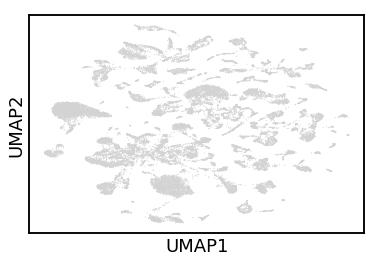

In [28]:
sc.pp.neighbors(bef)
sc.tl.umap(bef)
sc.pl.umap(bef)

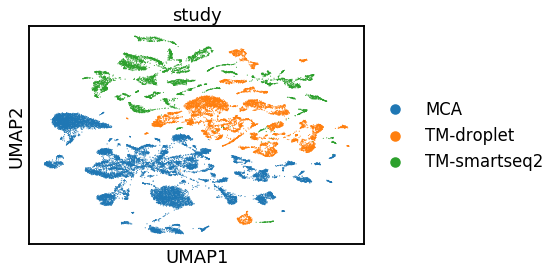

In [29]:
sc.pl.umap(bef, color='study')

In [37]:
import rpy2.robjects as ro
import anndata2ri
def readSeurat(path):
    anndata2ri.activate()
    ro.r('library(Seurat)')
    ro.r('library(scater)')
    ro.r(f'sobj <- readRDS("{path}")')
    adata = ro.r('as.SingleCellExperiment(sobj)')
    anndata2ri.deactivate()
    return(adata)

In [47]:
harmony = readSeurat('/home/icb/daniel.strobl/Benchmarking_data_integration/R/testemb.RDS')

In [48]:
harmony

AnnData object with n_obs × n_vars = 26668 × 18756 
    obs: 'barcode', 'batch', 'cell_type', 'cell_type_union', 'channel', 'log_counts', 'marker_gene', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'sample_id', 'sex', 'size_factors', 'study', 'tissue', 'nCount_RNA', 'nFeature_RNA', 'ident'
    obsm: 'X_pca', 'HARMONY', 'X_EMB'
    layers: 'logcounts'

In [51]:
harmony.obsm['X_EMB']

array([[-20.7865392 ,  12.70137032, -24.38083794, ...,   0.95045191,
          0.33671549,  -0.61524615],
       [-17.22466613,   0.81238821,  -7.05999939, ...,   2.37518798,
          6.86889414,  -1.09687343],
       [  2.67621482,   7.86127062,  -5.10554435, ...,   0.15353273,
         -0.46519647,   0.05256122],
       ...,
       [  5.75004168,  -0.89265738,  -1.5702898 , ...,  -0.03995508,
         -0.41412592,   0.07376729],
       [  2.27626571,   5.0571196 ,  -0.39346961, ...,  -0.46940854,
          0.14439199,   0.55210498],
       [-36.32872426, -22.91091229,   3.96634467, ...,   5.01464605,
         10.40415111,  -5.57468856]])

In [59]:
from scipy import sparse
def saveSCE(adata):
    ro.r('library(Seurat)')
    ro.r('library(scater)')
    anndata2ri.activate()

    if sparse.issparse(adata.X):
        if not adata.X.has_sorted_indices:
            adata.X.sort_indices()

    for key in adata.layers:
        if sparse.issparse(adata.layers[key]):
            if not adata.layers[key].has_sorted_indices:
                adata.layers[key].sort_indices()

    ro.globalenv['adata'] = adata
    ro.r('saveRDS(adata, "/home/icb/daniel.strobl/sce.RDS")')

In [67]:
adata = sc.read('/home/icb/daniel.strobl/group.daniela/small_test.h5ad')

In [68]:
scIB.pp.reduce_data(adata)

HVG
Computed 1999 highly variable genes
PCA
Nearest Neigbours


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


UMAP


/home/icb/daniel.strobl/miniconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


In [70]:
adata.write('/home/icb/daniel.strobl/small_test_red.h5ad')

In [71]:
adata.uns

OrderedDict([('pca',
              {'variance': array([244.48878  ,  95.42562  ,  51.218185 ,  39.834633 ,  30.07426  ,
                       28.529999 ,  23.966326 ,  21.152182 ,  19.548206 ,  14.767128 ,
                       11.765609 ,  11.117394 ,  10.017562 ,   7.704151 ,   6.150159 ,
                        5.3307357,   5.279168 ,   4.812432 ,   4.020188 ,   3.8532956,
                        3.5961857,   3.334168 ,   3.2330441,   2.9644623,   2.8140676,
                        2.7568367,   2.4666214,   2.1998875,   2.1223621,   2.0648322,
                        2.0009017,   1.9702258,   1.8233517,   1.7779053,   1.7158873,
                        1.6572548,   1.6168668,   1.541687 ,   1.5087569,   1.4908586,
                        1.4556797,   1.4094262,   1.3755609,   1.3557215,   1.3283931,
                        1.3143041,   1.3024893,   1.2874038,   1.2768195,   1.2738198],
                     dtype=float32),
               'variance_ratio': array([0.22759335, 0.08883

In [60]:
saveSCE(adata)

In [62]:
adata = sc.read('/home/icb/daniel.strobl/con.h5ad')

In [65]:
adata = sc.read('/home/icb/daniel.strobl/testConv.h5ad')

In [66]:
adata.uns

OrderedDict()

In [72]:
conos = sc.read('/home/icb/daniel.strobl/small_test_conos.h5ad')

In [76]:
conos.uns

OrderedDict([('neighbors',
              {'connectivities': <26668x26668 sparse matrix of type '<class 'numpy.float64'>'
               	with 527542 stored elements in Compressed Sparse Row format>,
               'distances': <26668x26668 sparse matrix of type '<class 'numpy.float64'>'
               	with 527542 stored elements in Compressed Sparse Row format>})])

In [83]:
con2 = sc.read('/home/icb/daniel.strobl/small_test_conos_new.h5ad')

In [84]:
con2.obs

,barcode,batch,cell_type,cell_type_union,channel,log_counts,marker_gene,n_counts,n_genes,percent_mito,sample,sample_id,sex,size_factors,study,tissue,nCount_RNA,nFeature_RNA,Dataset
index,,,,,,,,,,,,,,,,,,,
GGCAATTCATTCTCAT-0-1-1,nan,1,mesenchymal stem cell,stromal cell,10X_P7_15,NaN,nan,NaN,NaN,NaN,3-F-57,0,F,2.190977,TM-droplet,Muscle,1776.508331,2589,TM-droplet
GTACTTTAGCCGGTAA-3-1-1,nan,1,stromal cell,stromal cell,10X_P8_13,NaN,nan,NaN,NaN,NaN,3-M-7/8,3,M,0.769138,TM-droplet,Lung,1473.865063,1371,TM-droplet
TACACGACAAGCTGTT-5-1-1,nan,1,B cell,b cell,10X_P4_7,NaN,nan,NaN,NaN,NaN,3-M-8,5,M,0.800038,TM-droplet,Spleen,1238.802154,1131,TM-droplet
ACTGTCCCAAACGTGG-5-1-1,nan,1,macrophage,macrophage,10X_P7_6,NaN,nan,NaN,NaN,NaN,3-F-56,5,F,2.207479,TM-droplet,Spleen,1495.649478,2263,TM-droplet
TGCACCTGTACATGTC-1-1-1,nan,1,hepatocyte,hepatocyte,10X_P7_1,NaN,nan,NaN,NaN,NaN,3-F-57,1,F,4.401425,TM-droplet,Liver,1639.542651,3669,TM-droplet
GCTGGGTCAGTATAAG-7-1-1,nan,1,T cell,t cell,10X_P7_13,NaN,nan,NaN,NaN,NaN,3-F-57,7,F,0.515779,TM-droplet,Mammary,1833.870851,1205,TM-droplet
CATGACACATGTCGAT-2-1-1,nan,1,kidney capillary endothelial cell,kidney capillary endothelial cell,10X_P4_6,NaN,nan,NaN,NaN,NaN,3-M-9,2,M,0.860275,TM-droplet,Kidney,2053.703538,1940,TM-droplet
ACTTACTTCTCTTATG-7-1-1,nan,1,T cell,t cell,10X_P7_13,NaN,nan,NaN,NaN,NaN,3-F-57,7,F,0.487394,TM-droplet,Mammary,1889.024770,1195,TM-droplet
AACTGGTGTAGAGTGC-1-1-1,nan,1,hepatocyte,hepatocyte,10X_P7_0,NaN,nan,NaN,NaN,NaN,3-F-56,1,F,2.040397,TM-droplet,Liver,1554.182195,2274,TM-droplet
